In [ ]:
# !pip install catboost
# !pip install xgboost

In [3]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from utils import plot_calibration_curve, plot_overlap
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from functools import partial
import concurrent.futures
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import tqdm
import ast

RANDOM_SEED = 42

# Load Data

In [2]:
partial_df = pd.read_csv('Final_Data/feature_df.csv', index_col=0)
full_df = pd.read_csv('Final_Data/full_scores_feature_df.csv', index_col=0)

# train_df = pd.read_csv('Final_Data/train_feature_df.csv', index_col=0)
# eval_df = pd.read_csv('Final_Data/eval_feature_df.csv', index_col=0)

# Models

In [3]:
lr_model_class = partial(LogisticRegression, max_iter=10000, random_state=RANDOM_SEED)
rf_model_class = partial(RandomForestClassifier, n_estimators=50, max_depth=50, random_state=RANDOM_SEED)
gb_model_class = partial(GradientBoostingClassifier, n_estimators=10, max_depth=5, min_samples_leaf=5, learning_rate=0.5, random_state=RANDOM_SEED)
xgb_model_class = partial(xgb.XGBClassifier, n_estimators=20, max_depth=20, learning_rate=0.2, subsample=0.6, random_state=RANDOM_SEED)

# with open('Models.pkl', 'rb') as f:
#     models = pickle.load(f)

# with open('SLearner_Models.pkl', 'rb') as f:
#     slearner_hp = pickle.load(f)

# Propensity Score

In [4]:
def estemite_e(df, model):
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
    
    X = df.drop(columns=['T', 'Y'])
    y = df['T']
    
    if type(model).__name__ in ["LogisticRegression", "SVC", "RandomForestClassifier","GradientBoostingClassifier", "XGBClassifier"]:
        dummied_df = pd.get_dummies(X[categorical_cols], prefix=categorical_cols).astype(int)
        X = pd.concat([X.drop(categorical_cols, axis=1), dummied_df], axis=1)
    
    if type(model).__name__ == ['LogisticRegression', 'SVC']:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
    
    model.fit(X, y)
    
    print(type(model).__name__)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    return y_pred_proba

############################ Propensity eval ################################
propensity_score_lr = estemite_e(full_df, lr_model_class())
propensity_score_rf = estemite_e(full_df, rf_model_class())
propensity_score_gb = estemite_e(full_df, gb_model_class())
propensity_score_xgb = estemite_e(full_df, xgb_model_class())

LogisticRegression
RandomForestClassifier
GradientBoostingClassifier
XGBClassifier


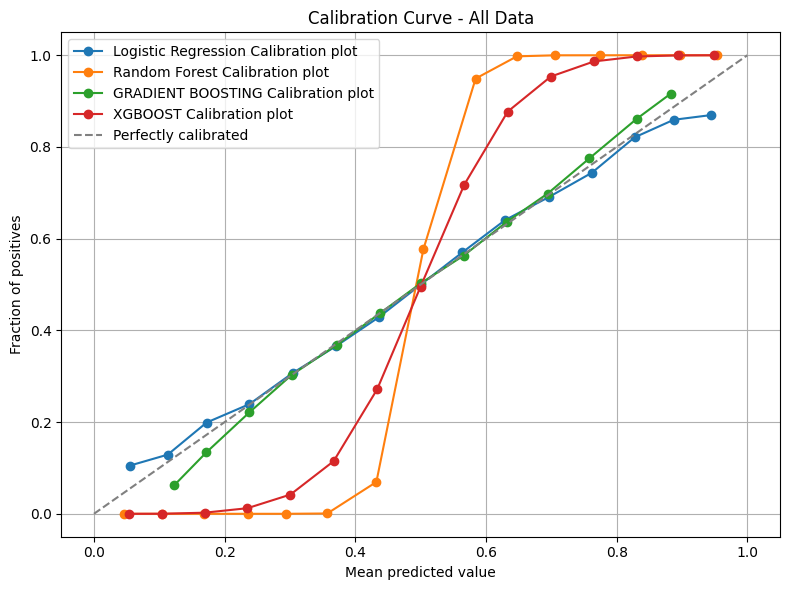

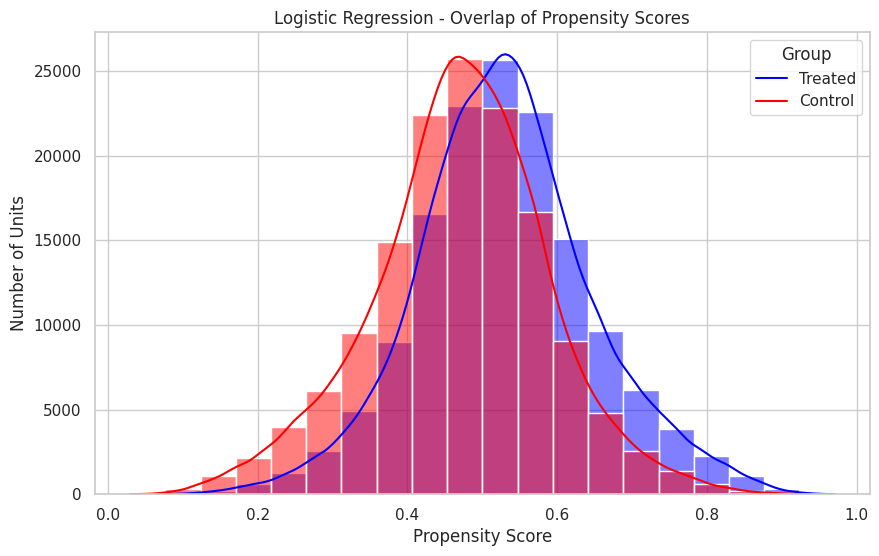

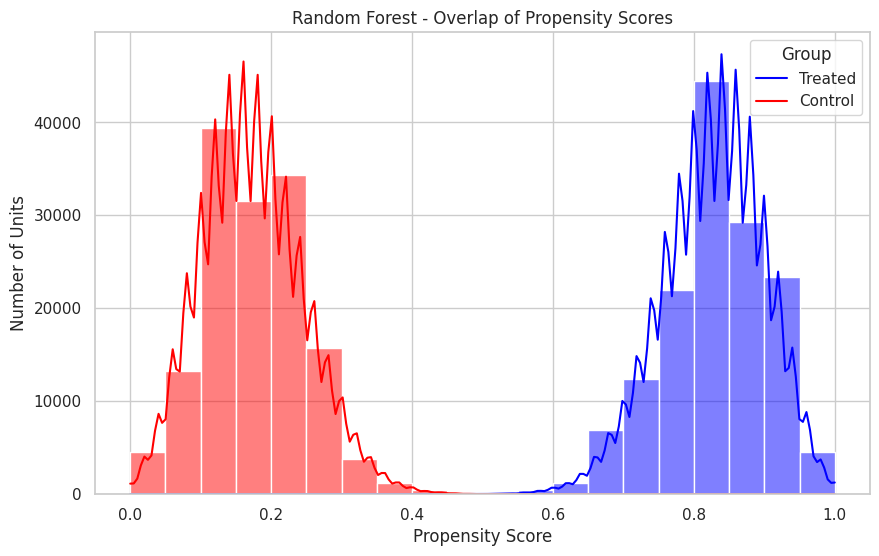

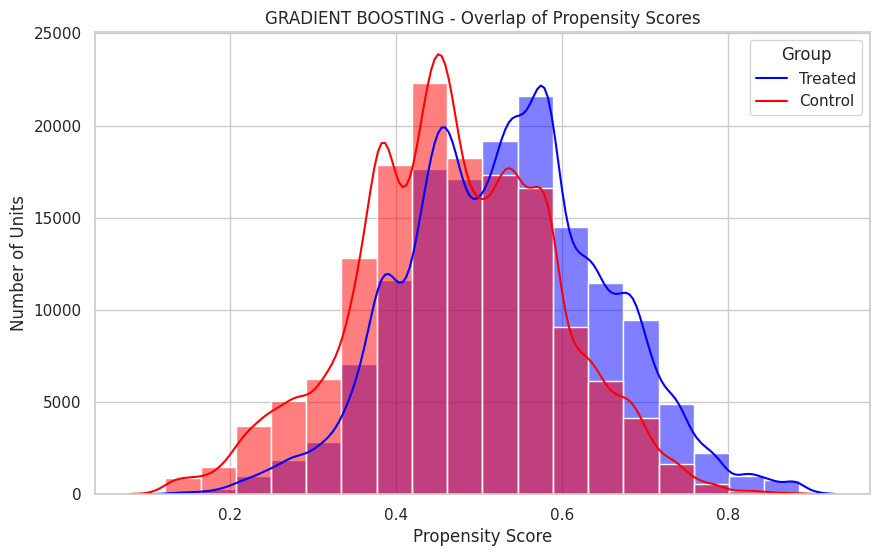

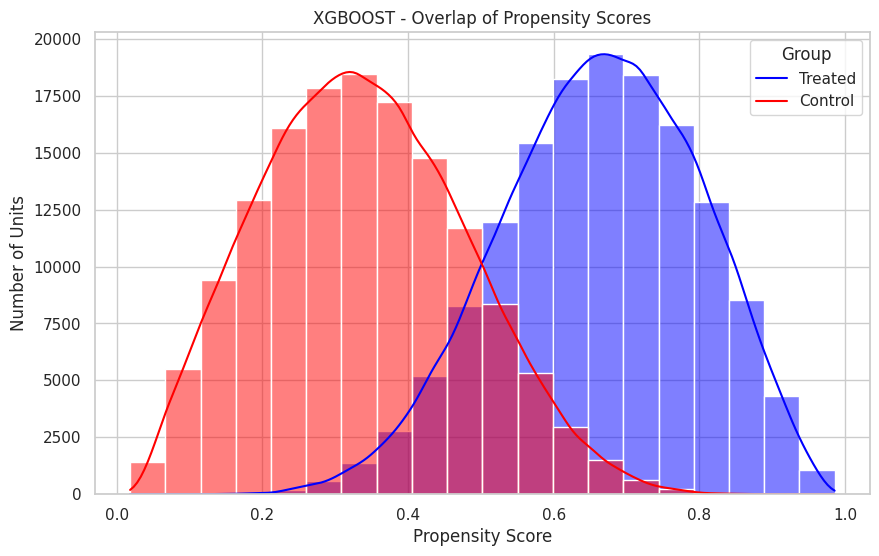

In [5]:
plot_calibration_curve(full_df['T'], {'Logistic Regression': propensity_score_lr,
                                        'Random Forest': propensity_score_rf,
                                        'GRADIENT BOOSTING': propensity_score_gb,
                                        'XGBOOST': propensity_score_xgb,
                                        })

plot_overlap(full_df['T'], propensity_score_lr, model_name='Logistic Regression')
plot_overlap(full_df['T'], propensity_score_rf, model_name='Random Forest')
plot_overlap(full_df['T'], propensity_score_gb, model_name='GRADIENT BOOSTING')
plot_overlap(full_df['T'], propensity_score_xgb, model_name='XGBOOST')

# IPW

In [6]:
def IPW_ATE(df, propensity_score):
    n = len(df)
    y1 = df.loc[df['T'] == 1, 'Y']
    y0 = df.loc[df['T'] == 0, 'Y']

    assert n == len(y1) + len(y0), "Mismatch"

    ATT_ipw = (sum(y1 / propensity_score[df['T'] == 1]) - sum(y0 / (1 - propensity_score[df['T'] == 0]))) / n

    return ATT_ipw

#############################################################################
IPW_ATE_df = IPW_ATE(full_df, propensity_score_lr)

ATE_df = pd.DataFrame({'Method': ['IPW'], 'ATE': [IPW_ATE_df]})
ATE_df

,Method,ATE
0,IPW,0.251228


# Find Best Model For S/T-Learner

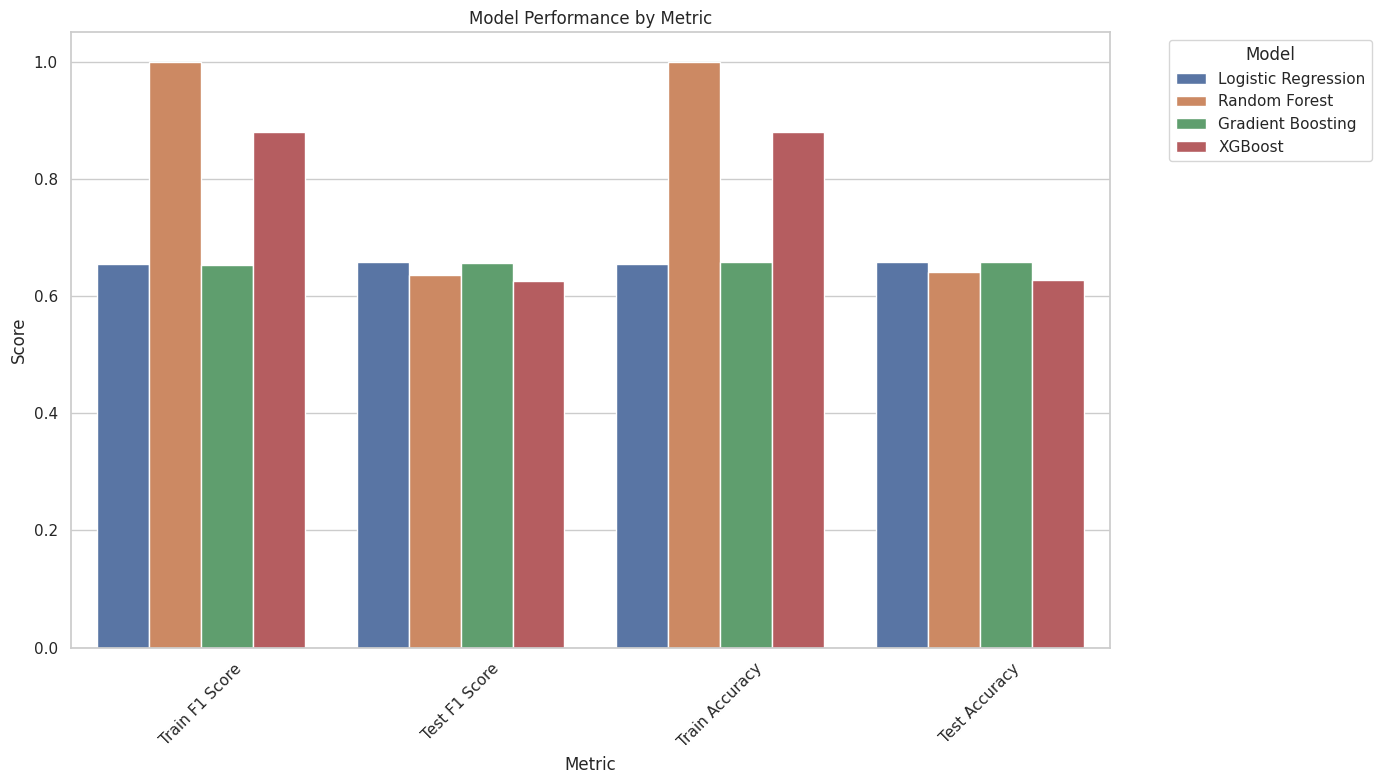

In [7]:
def evaluate_model(df, model, test_size=0.2, random_state=42):
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
    X = df.drop(columns=['Y'])
    y = df['Y']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    if type(model).__name__ in ["LogisticRegression", "SVC", "RandomForestClassifier", "GradientBoostingClassifier", "XGBClassifier"]:
        X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
        X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
        
        X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    if type(model).__name__ in ['LogisticRegression', 'SVC']:
        scaler = MinMaxScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metrics = {
        'Train F1 Score': f1_score(y_train, y_train_pred),
        'Test F1 Score': f1_score(y_test, y_test_pred),
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
    }

    return metrics
#############################################################################

models = {
    "Logistic Regression": lr_model_class(),
#     "Support Vector Machine": svm_model_class(),
    "Random Forest": rf_model_class(),
    "Gradient Boosting": gb_model_class(),
    "XGBoost": xgb_model_class()
}

all_metrics = {}
for model_name, model in models.items():
    metrics = evaluate_model(full_df, model)
    all_metrics[model_name] = metrics

results_df = pd.DataFrame(all_metrics).T
results_df = results_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
results_df.rename(columns={'index': 'Model'}, inplace=True)
results_df.set_index(['Metric', 'Model'], inplace=True)

plt.figure(figsize=(14, 8))
sns.barplot(x='Metric', y='Score', hue='Model', data=results_df.reset_index(), errorbar=None)
plt.title('Model Performance by Metric')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# S-Learner

In [8]:
def SLearner_ATE(df, model):
  categorical_cols = [col for col in df.columns if df[col].dtype == 'object']

  X = df.drop(columns=['Y'])  
  y = df['Y']

  if type(model).__name__ in ["LogisticRegression", "RandomForestClassifier", "GradientBoostingClassifier", "XGBClassifier"]:
    dummied_df = pd.get_dummies(X[categorical_cols], prefix=categorical_cols).astype(int)
    X = pd.concat([X.drop(categorical_cols, axis=1), dummied_df], axis=1)

  if type(model).__name__ in ['LogisticRegression']:
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)

  if type(model).__name__ in ['CatBoostClassifier']:
      model.fit(X, y, cat_features=categorical_cols)
  else:
      model.fit(X, y)

  x1 = X.copy()
  x0 = X.copy()
  x1['T'], x0['T'] = 1, 0

  y1_pred = model.predict(x1)
  y0_pred = model.predict(x0)

  ATE = (y1_pred - y0_pred).mean()
  return ATE

#############################################################################
SLearner_ATE_df = SLearner_ATE(full_df, model=rf_model_class())
new_row = pd.DataFrame({'Method': ['S-learner'], 'ATE': [SLearner_ATE_df]})
ATE_df = pd.concat([ATE_df, new_row], ignore_index=True)
ATE_df

,Method,ATE
0,IPW,0.251228
1,S-learner,0.405082


# T-Learner

In [9]:
def TLearner_ATE(df, model0, model1):
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object']

    X = df.drop(columns=['Y']).reset_index(drop=True)
    y = df['Y'].reset_index(drop=True)
    treatment = df['T'].reset_index(drop=True)

    if type(model1).__name__ in ['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier', 'XGBClassifier']:
        dummied_df_X = pd.get_dummies(X[categorical_cols], prefix=categorical_cols).astype(int)
        X = pd.concat([X.drop(categorical_cols, axis=1), dummied_df_X], axis=1)

    if type(model1).__name__ == 'LogisticRegression':
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
        X = pd.DataFrame(X_scaled, columns=X.columns)

    X1 = X[treatment == 1].drop(columns=['T'])
    y1 = y[treatment == 1].reset_index(drop=True)
    X0 = X[treatment == 0].drop(columns=['T'])
    y0 = y[treatment == 0].reset_index(drop=True)

    if type(model1).__name__ == 'CatBoostClassifier':
        model1.fit(X1, y1, cat_features=categorical_cols)
        model0.fit(X0, y0, cat_features=categorical_cols)
    else:
        model1.fit(X1, y1)
        model0.fit(X0, y0)

    y1_pred = model1.predict(X.drop(columns=['T']))
    y0_pred = model0.predict(X.drop(columns=['T']))

    ATE = (y1_pred - y0_pred).mean()
    return ATE

#############################################################################
SLearner_ATE_df = TLearner_ATE(full_df, model0=lr_model_class(), model1=lr_model_class())
print("Estimated ATE (Logistic Regression):", SLearner_ATE_df)

SLearner_ATE_df = TLearner_ATE(full_df, model0=rf_model_class(), model1=rf_model_class())
print("Estimated ATE (Random Forest):", SLearner_ATE_df)

SLearner_ATE_df = TLearner_ATE(full_df, model0=gb_model_class(), model1=gb_model_class())
print("Estimated ATE (Gradient Boosting):", SLearner_ATE_df)

SLearner_ATE_df = TLearner_ATE(full_df, model0=xgb_model_class(), model1=xgb_model_class())
print("Estimated ATE (XGBoost):", SLearner_ATE_df)


TLearner_ATE_df = TLearner_ATE(full_df, model0=rf_model_class(), model1=rf_model_class())

new_row = pd.DataFrame({'Method': ['T-learner'], 'ATE': [TLearner_ATE_df]})
ATE_df = pd.concat([ATE_df, new_row], ignore_index=True)
ATE_df

Estimated ATE (Logistic Regression): 0.8106210241207664
Estimated ATE (Random Forest): 0.4110527280714802
Estimated ATE (Gradient Boosting): 0.7740092083006154
Estimated ATE (XGBoost): 0.4800319626963509


,Method,ATE
0,IPW,0.251228
1,S-learner,0.405082
2,T-learner,0.411053


# Matching

In [10]:
def Matching_ATE(df, epsilon=0.1):
    df_norm = df.copy()
    df_norm = df_norm.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

    categorical_cols = df_norm.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = df_norm.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col not in ['Y', 'T']]

    dummied_df_X = pd.get_dummies(df_norm[categorical_cols], drop_first=True)
    X = pd.concat([df_norm[numerical_cols], dummied_df_X, df_norm[['T', 'Y']]], axis=1)

    scaler = MinMaxScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

    X1 = X[X['T'] == 1].reset_index(drop=True)
    X0 = X[X['T'] == 0].reset_index(drop=True)

    # Use NearestNeighbors to find closest matches
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='euclidean').fit(X0.drop(columns=['T', 'Y']).values)
    distances, min_indices = nbrs.kneighbors(X1.drop(columns=['T', 'Y']).values)

    # Filter for valid matches
    valid_matches = distances.flatten() < epsilon
    valid_min_indices = min_indices.flatten()[valid_matches]
    counts = np.bincount(valid_min_indices)
    unique_indices = np.where(counts == 1)[0]

    # Keep only treated indices that correspond to unique matches
    treated_indices_with_unique_matches = np.where(valid_matches)[0][np.isin(valid_min_indices, unique_indices)]

    if len(treated_indices_with_unique_matches) > 0:
        treated_Y_values = X1['Y'].values[treated_indices_with_unique_matches]
        control_Y_values = X0.loc[valid_min_indices[np.isin(valid_min_indices, unique_indices)], 'Y'].values

        # Calculate ATE
        ATE = treated_Y_values - control_Y_values
        return ATE.mean()
    else:
        return np.nan

#############################################################################
epsilon = 0.1  
matching_ATE = Matching_ATE(full_df, epsilon)

new_row = pd.DataFrame({'Method': ['Matching'], 'ATE': [matching_ATE]})
ATE_df = pd.concat([ATE_df, new_row], ignore_index=True)
ATE_df

,Method,ATE
0,IPW,0.251228
1,S-learner,0.405082
2,T-learner,0.411053
3,Matching,0.255594


# Doubly - Robust

In [11]:
def DR_ATE(df, model0, model1, propensity_score):
    model_name = type(model1).__name__
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object']

    X = df.drop(columns=['Y'])
    y = df['Y']

    if model_name in ['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier', 'XGBClassifier']:
      dummied_df_X = pd.get_dummies(X[categorical_cols], prefix=categorical_cols).astype(int)
      X = pd.concat([X.drop(categorical_cols, axis=1), dummied_df_X], axis=1)

    if model_name in ['LogisticRegression']:
      scaler = MinMaxScaler()
      X_scaled = scaler.fit_transform(X)
      X = pd.DataFrame(X_scaled, columns=X.columns)

    X1, y1 = X[X['T'] == 1].drop(columns=['T']), y[X['T'] == 1]
    X0, y0 = X[X['T'] == 0].drop(columns=['T']), y[X['T'] == 0]

    if model_name in ['CatBoostClassifier']:
        model1.fit(X1, y1, cat_features=categorical_cols)
        model0.fit(X0, y0, cat_features=categorical_cols)
    else:
       model1.fit(X1, y1)
       model0.fit(X0, y0)

    y1_pred = model1.predict(X.drop(columns=['T']))
    y0_pred = model0.predict(X.drop(columns=['T']))

    # ATE
    g1 = y1_pred + (df['T'].to_numpy() / propensity_score)*(y - y1_pred)
    g0 = y0_pred + ((1-df['T'].to_numpy()) / (1-propensity_score))*(y - y0_pred)
    return (g1 - g0).mean()

#############################################################################
DR_ATE_df = DR_ATE(full_df, model0=rf_model_class(), model1=rf_model_class(), propensity_score=propensity_score_lr)

new_row = pd.DataFrame({'Method': ['Doubly Robust'], 'ATE': [DR_ATE_df]})
ATE_df = pd.concat([ATE_df, new_row], ignore_index=True)
ATE_df

,Method,ATE
0,IPW,0.251228
1,S-learner,0.405082
2,T-learner,0.411053
3,Matching,0.255594
4,Doubly Robust,0.410855


# CI

In [12]:
def bootstrap_iter(sample_df, method, propensity_score, model_class):
    """
    This function runs a single bootstrap iteration.
    """
    if method == "IPW":
        result = IPW_ATE(sample_df, propensity_score)
    elif method == "S-learner":
        result = SLearner_ATE(sample_df, model_class())
    elif method == "T-learner":
        result = TLearner_ATE(sample_df, model_class(), model_class())
    elif method == "Matching":
        result = Matching_ATE(sample_df, epsilon=0.1)
    elif method == "Doubly Robust":
        result = DR_ATE(sample_df, model_class(), model_class(), propensity_score)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    return result

def calc_bootstrap_CI(df, method, propensity_score, model_class):
    df['propensity_score'] = propensity_score
    print(method)

    ATEs = []
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        
        for _ in tqdm.tqdm(range(300)):  # Decrease the range for testing or debugging
            sample_df = df.sample(n=len(df), replace=True)
            sample_propensity_score = sample_df['propensity_score'].to_numpy()
            sample_df = sample_df.drop(columns='propensity_score')

            futures.append(executor.submit(bootstrap_iter, sample_df, method, sample_propensity_score, model_class))
        
        for future in tqdm.tqdm(concurrent.futures.as_completed(futures)):
            ATEs.append(future.result())
    
    lower_bound = round(np.percentile(ATEs, 2.5), 3)
    upper_bound = round(np.percentile(ATEs, 97.5), 3)
    
    return [lower_bound, upper_bound]

#############################################################################
ATE_df['CI'] = ATE_df['Method'].apply(lambda method: calc_bootstrap_CI(full_df, method, propensity_score_lr, rf_model_class))
ATE_df

IPW


100% 300/300 [00:30<00:00,  9.78it/s]
300it [00:00, 4687.82it/s]


S-learner


100% 300/300 [00:17<00:00, 17.42it/s]
300it [35:03,  7.01s/it]


T-learner


100% 300/300 [00:19<00:00, 15.76it/s]
300it [33:59,  6.80s/it]


Matching


100% 300/300 [00:18<00:00, 16.28it/s]
300it [1:19:08, 15.83s/it]


Doubly Robust


100% 300/300 [00:18<00:00, 16.63it/s]
300it [33:52,  6.77s/it]


,Method,ATE,CI
0,IPW,0.251228,"[0.246, 0.258]"
1,S-learner,0.405082,"[0.394, 0.406]"
2,T-learner,0.411053,"[0.4, 0.412]"
3,Matching,0.255594,"[0.247, 0.267]"
4,Doubly Robust,0.410855,"[0.4, 0.413]"


In [19]:
ATE_df.to_csv('ate_full_df.csv')

In [4]:
ate_full_df = pd.read_csv('ate_full_df.csv', index_col=0)
ate_partial_df = pd.read_csv('ate.csv', index_col=0)

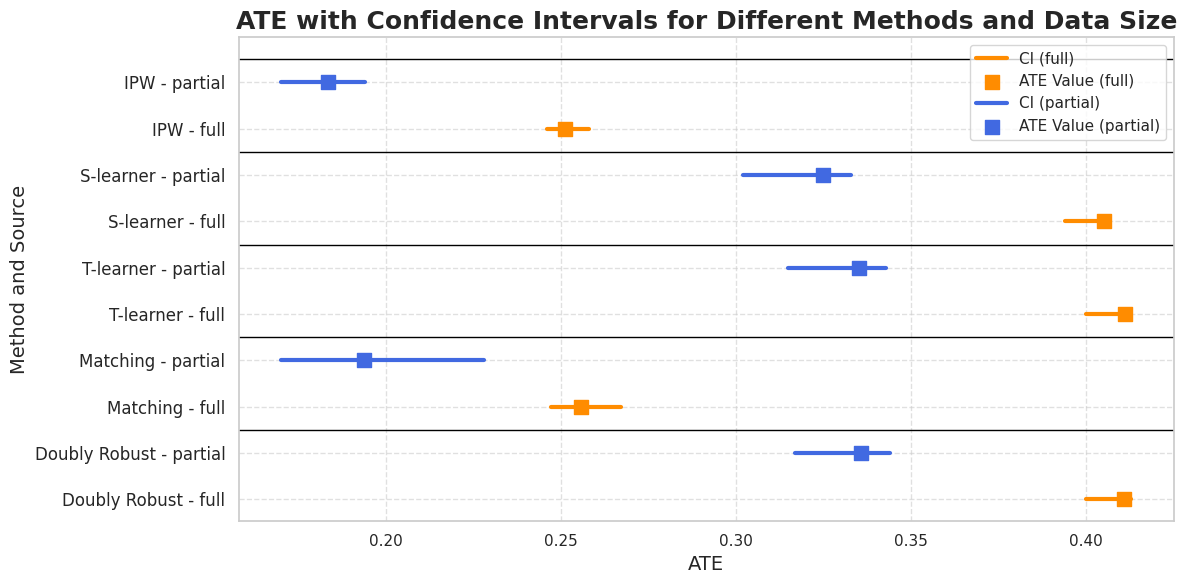

In [5]:
ate_full_df['Source'] = 'full'
ate_partial_df['Source'] = 'partial'
combined_df = pd.concat([ate_full_df, ate_partial_df], ignore_index=True)
combined_df.set_index(['Method', 'Source'], inplace=True)
ordered_methods = reversed(['IPW', 'S-learner', 'T-learner', 'Matching', 'Doubly Robust'])
combined_df = combined_df.loc[
    pd.MultiIndex.from_product([ordered_methods, ['full', 'partial']])
]

sns.set_theme(style="whitegrid", palette="muted")
plt.figure(figsize=(12, 6))

ci_full_label_added = False
ate_full_label_added = False
ci_partial_label_added = False
ate_partial_label_added = False

for i, (index, row) in enumerate(combined_df.iterrows()):
    method, source = index
    ate_value = row['ATE']
    lower_ci, upper_ci = ast.literal_eval(row['CI'])  # Convert string list to actual list
    
    if source == 'full':
        color = 'darkorange'
    else:
        color = 'royalblue'

    if source == 'full' and not ci_full_label_added:
        plt.plot([lower_ci, upper_ci], [i, i], color=color, lw=3, label=f'CI ({source})')  # Line for CI
        ci_full_label_added = True
    elif source == 'partial' and not ci_partial_label_added:
        plt.plot([lower_ci, upper_ci], [i, i], color=color, lw=3, label=f'CI ({source})')  # Line for CI
        ci_partial_label_added = True
    else:
        plt.plot([lower_ci, upper_ci], [i, i], color=color, lw=3)  # Line for CI without label
    
    if source == 'full' and not ate_full_label_added:
        plt.scatter(ate_value, i, color=color, marker='s', s=100, zorder=5, label=f'ATE Value ({source})')  # Square markers for ATE
        ate_full_label_added = True
    elif source == 'partial' and not ate_partial_label_added:
        plt.scatter(ate_value, i, color=color, marker='s', s=100, zorder=5, label=f'ATE Value ({source})')  # Square markers for ATE
        ate_partial_label_added = True
    else:
        plt.scatter(ate_value, i, color=color, marker='s', s=100, zorder=5)  # Square markers for ATE without label

    if i % 2 == 1:  # After each pair (full and partial)
        plt.axhline(y=i + 0.5, color='black', linestyle='-', linewidth=1)

plt.grid(True, linestyle='--', alpha=0.6)
plt.title('ATE with Confidence Intervals for Different Methods and Data Size', fontsize=18, fontweight='bold')
plt.xlabel('ATE', fontsize=14)
plt.ylabel('Method and Source', fontsize=14)
yticks = range(len(combined_df))
yticklabels = [f'{method} - {source}' for method, source in combined_df.index]
plt.yticks(yticks, yticklabels, fontsize=12)

plt.legend()
plt.tight_layout()
plt.show()
